This is a testing notebook for the GLMAT estimation algorithm. We simulate data using the biophysical dSTRF model (biocm or pospischil), and then try to estimate parameters with the GLMAT model. The GLMAT model does not have a membrane, so the estimated RF should be the convolution of the input kernel ($k1$) with the membrane kernel ($k2$) which is approximately an exponential decay with time constant $\tau_m$. However, what can happen is that the kernel gets shifted to shorter lags for the phasic model, which is consistent with what Chen and Meliza (2018) found for the coherence between an input current and the spiking output - the dynamics act as a bandpass filter.

In [1]:
from __future__ import print_function, division
import sys
import imp
import os
import numpy as np
import scipy as sp
import scipy.signal as sps
import quickspikes as qs

import mat_neuron._model as mat
from dstrf import strf, mle
import spyks.core as spkc

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# model parameters: (ω, α1, α2, τ1, τ2, tref)
matparams = np.asarray([7, 100, 2, 10, 200, 2], dtype='d')
model_dt = 0.5

matparams_i = [0,1,2]
matparams_n = len(matparams_i)
matparams_f = matparams[matparams_i]

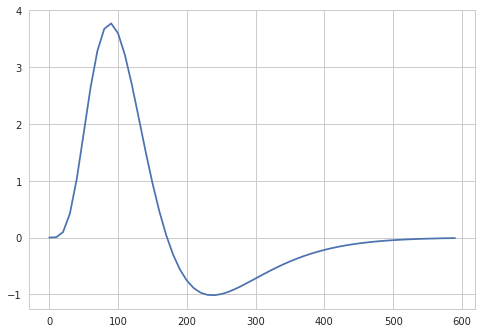

In [3]:
# convolution kernel
from dstrf import filters
stim_dt = 10.0
ntau = 60
upsample = int(stim_dt / model_dt)
ntbas = 8
kscale = 2.0

# raised-cosine basis functions
kcosbas = strf.cosbasis(ntau, ntbas)
ntbas = kcosbas.shape[1]

k1, kt = filters.gammadiff(ntau * stim_dt / 32, ntau * stim_dt / 16, 5, ntau * stim_dt, stim_dt)
k1 = k1 * kscale
k1c = strf.to_basis(k1, kcosbas)

plt.plot(kt, k1)

In [4]:
# generating spikes with biocm
# this needs to be adjusted on a per model basis. posp ~ 2.0; phasic ~ 10
# model_name = "biocm_phasic.yml"
# current_scaling = 9.0
# model_name = "biocm_tonic.yml"
# current_scaling = 4.0
model_name = "pospischil_sm.yml"
current_scaling = 2.0

trial_noise_sd = 2.0
spike_thresh = -20
dt_rise_time = int(1.0 / model_dt)
modelpath = "../../models"
pymodel = spkc.load_model(os.path.join(modelpath, model_name))
biocm_params = spkc.to_array(pymodel["parameters"])
biocm_state0 = spkc.to_array(pymodel["state"])
biocm_model = spkc.load_module(pymodel, modelpath)
    
def filter_stimulus(S, k1):
    return np.convolve(S, k1, mode="full")[:S.size]

def generate_spikes(I, noise_sd, dt, upsample):
    from scipy.signal import resample
    I_noise = np.random.randn(I.size) * noise_sd
    I = current_scaling * (I + I_noise)
    #I_resamp = sps.resample(I + I_noise, I.size * upsample)
    X = biocm_model.integrate(biocm_params, biocm_state0, I, stim_dt, model_dt)
    det = qs.detector(spike_thresh, dt_rise_time)
    return I, X[:, 0], det(X[:, 0])

In [5]:
# data parameters
duration = 100000
n_bins = int(duration / model_dt)
n_frames = n_bins // upsample
n_assim = 10
n_test = 10

# generate data to fit
np.random.seed(1)
mat.random_seed(1)
data = []
stim = np.random.randn(n_frames)
stim[:100] = 0
        
I = filter_stimulus(stim, k1)
for i in range(n_assim):
    In, V, spike_t = generate_spikes(I, trial_noise_sd, model_dt, upsample)
    spike_v = np.zeros(V.size, 'i')
    spike_v[spike_t] = 1
    H = mat.adaptation(spike_v, matparams[3:5], model_dt)
    d = {"H": H,
         "duration": duration,
         "spike_t": np.asarray(spike_t), 
         "spike_v": spike_v,
        }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:]

spikes: 414.0; rate: 0.00414 / dt


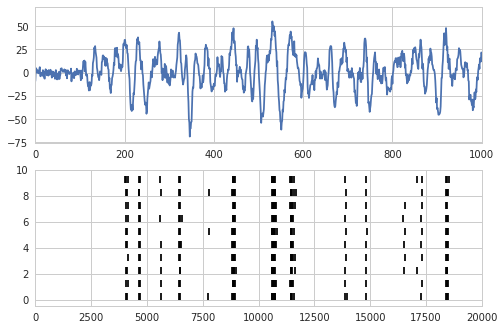

In [8]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
for i, d in enumerate(data):
    ax2.vlines(d["spike_t"], i, i + 0.5)
ax1.plot(In)
ax1.set_xlim(0, 20000 / upsample)
ax2.set_xlim(0, 20000)
print("spikes: {}; rate: {} / dt".format(np.mean([d["spike_t"].size for d in data]), 
                                         np.mean([d["spike_t"].size / d["duration"] for d in data])))

In [9]:
# initial guess of parameters using regularized ML
ntbas = 8
kcosbas = strf.cosbasis(ntau, ntbas)
spike_v = np.stack([d["spike_v"] for d in assim_data], axis=1)
spike_h = np.stack([d["H"] for d in assim_data], axis=2)
mlest = mle.mat(stim, kcosbas, spike_v, spike_h, stim_dt, model_dt, nlin="exp")
%time w0 = mlest.estimate(reg_alpha=1.0)

         Current function value: 14310.436230
         Iterations: 26
         Function evaluations: 109
         Gradient evaluations: 125
         Hessian evaluations: 132
CPU times: user 43.9 s, sys: 5.22 s, total: 49.1 s
Wall time: 49.1 s


[ 12.81159373  10.12826918   1.66229742]


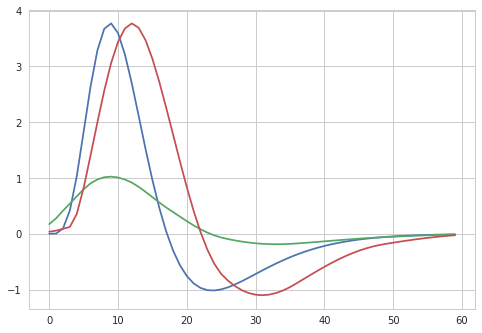

In [10]:
print(w0[:3])
rf_sta = strf.from_basis(mlest.sta(), kcosbas)
rf_ml = strf.from_basis(w0[3:], kcosbas)[::-1]
plt.plot(k1)
plt.plot(rf_sta[::-1])
plt.plot(rf_ml * k1.max() / rf_ml.max())

In [11]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos
import emcee

# assimilation parameters
if sys.platform == 'darwin':
    nthreads = 1
else:
    nthreads = 8
nwalkers = 500
nsteps = 2000

mat_prior = priors.joint_independent(
                [ priors.uniform( 0,  20),
                  priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                ])

# lasso prior on RF parameters
rf_lambda = 1.0

def matbounds(t1, t2, tr):
    aa1 = -(1 - np.exp(-tr/t2))/(1 - np.exp(-tr/t1))
    aa2 = -(np.exp(tr/t2) - 1)/(np.exp(tr/t1) - 1)
    def f(mparams):
        return (mparams[2] > aa1 * mparams[1]) and (mparams[2] > aa2 * mparams[1])
    return f

matboundprior = matbounds(*matparams[3:6])

def lnprior(theta):
    mparams = theta[:3]
    rfparams = theta[3:]
    if not matboundprior(mparams):
        return -np.inf
    rf_prior = -np.sum(np.abs(rfparams)) * rf_lambda
    ll = mat_prior(mparams) + rf_prior
    if not np.isfinite(ll):
        return -np.inf
    else:
        return ll


def loglike_poisson(V, H, spike_t, alpha, dt):
    mu = V - np.dot(H, alpha)
    return mu[spike_t].sum() - np.exp(mu).sum() * dt 


def loglike_sigmoid(V, H, spike_t, alpha, dt):
    mu = V - np.dot(H, alpha)
    lmb = (1 + np.tanh(mu / 2)) / 2
    return np.log(lmb[spike_t]).sum() - lmb.sum() * dt 


def loglike_softplus(V, H, spike_t, alpha, dt):
    mu = V - np.dot(H, alpha)
    lmb = np.log1p(np.exp(mu))
    return np.log(lmb[spike_t]).sum() - lmb.sum() * dt 
    
    
def lnlike(theta):
    mparams = theta[:3]
    rfparams = theta[3:]
    Vi = mlest.V_interp(theta).squeeze() - mparams[0]
    lp = 0
    for d in assim_data:
        lp += loglike_softplus(Vi, d["H"], d["spike_t"], mparams[1:3], model_dt)
    return lp   

def lnpost_dyn(theta):
    """Posterior probability for dynamical parameters"""
    return lnprior(theta) - mlest.loglike(theta) #+ lnlike(theta) 
    

In [12]:
# theoretically this is as good as it can get
theta_true = np.concatenate([matparams_f, k1c])
print("lnpost of p_true: {}".format(lnpost_dyn(theta_true)))
# initial state is a gaussian ball around the ML estimate
p0 = startpos.normal_independent(nwalkers, w0, np.abs(w0) * 2)
theta_0 = np.median(p0, 0)
print("lnpost of p0 median: {}".format(lnpost_dyn(theta_0)))
%timeit lnpost_dyn(theta_true)

lnpost of p_true: -47979819312.8
lnpost of p0 median: -14481.6481341
10 loops, best of 3: 74.9 ms per loop


In [13]:
sampler = emcee.EnsembleSampler(nwalkers, theta_true.size, lnpost_dyn, threads=nthreads)
tracker = utils.convergence_tracker(nsteps, 25)

for pos, prob, _ in tracker(sampler.sample(p0, iterations=nsteps)): 
    continue

  step  μ(lnprob)  Δ(lnprob)  σ(lnprob)        time         ETA
------------------------------------------------------------------
    25  -4.8108e+07        inf  9.6782e+08     0:02:57     4:04:14
    50     -14487  4.8093e+07     252.38     0:05:55     3:56:09
    75     -14354     132.82     260.11     0:08:53     3:51:22
   100     -14343     11.884     169.83     0:11:51     3:47:38
   125     -14333     9.5613     2.5625     0:14:49     3:44:13
   150     -14333     0.2887     2.4151     0:17:46     3:40:53
   175     -14333    0.16991     2.3765     0:20:45     3:37:47
   200     -14333  -0.055074      2.397     0:23:42     3:34:38
   225     -14333   -0.13823     2.5397     0:26:41     3:31:37
   250     -14333   0.035986     2.4391     0:29:39     3:28:30
   275     -14332    0.48561     2.2111     0:32:37     3:25:30
   300     -14332   -0.25203     2.4433     0:35:34     3:22:25
   325     -14332  8.2691e-05     2.2548     0:38:32     3:19:22
   350     -14332   0.014398    

lnpost of p median: -14332.1792728
average acceptance fraction: 0.391911
[ 12.81159373  10.12826918   1.66229742]
[ 12.80908161  10.13399419   1.65861556]


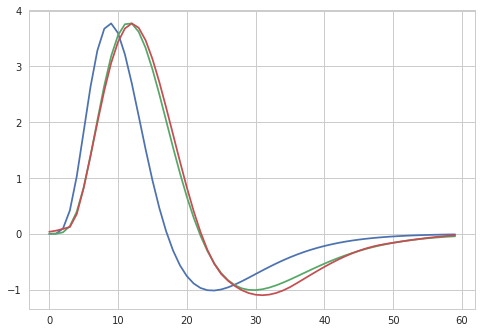

In [14]:
# save the results
outfile = os.path.join("..", "..", "results", "1d_rothman", model_name)

print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
theta = np.median(pos, 0)
mparams = theta[:matparams_n]
rfparams = theta[matparams_n:]
plt.plot(k1)

# there is an expected shift due to the filtering properties of the membrane
km, kmt = filters.exponential(46, 1.0, ntau * stim_dt, stim_dt)
kconv = np.convolve(km, k1, mode="full")[:km.size]
kconv *= k1.max() / kconv.max()
plt.plot(kconv)

kmap = strf.from_basis(rfparams, kcosbas)[::-1]
kmap *= k1.max() / kmap.max()
plt.plot(kmap)

print(w0[:3])
print(theta[:matparams_n])

plt.savefig(outfile + "_rf.pdf")

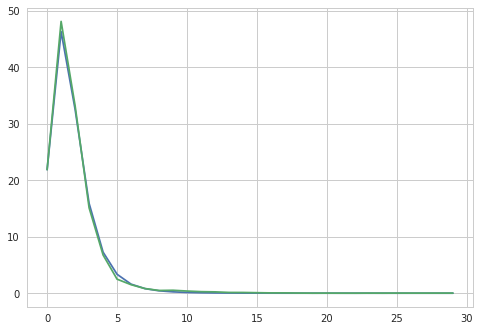

In [15]:
for ff in (kconv, kmap):
    K = np.fft.fft(ff)
    plt.plot(np.absolute(K[:K.size//2]))

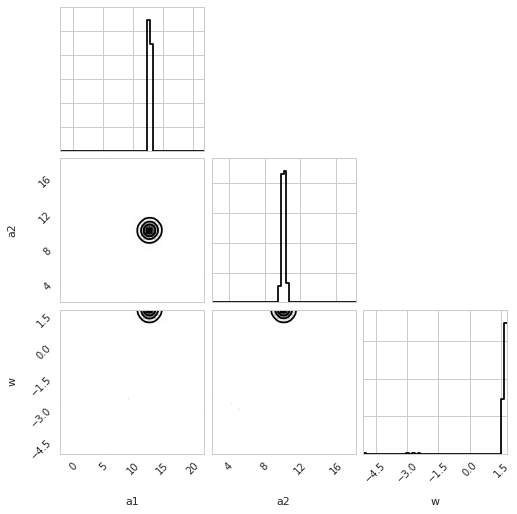

In [16]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:matparams_n]
matlabs = ['a1','a2','w']
c = corner(mpos,
           #range=[sp for sp in startparams],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs)

In [17]:
# simulate test data
def predict_spikes_current(I, params, dt, upsample):
    state = mat.voltage(I, fullmatparams, dt, upsample=upsample)
    V = state[:, 0]
    return V, predict_spikes_voltage(V, params, dt, 1)

def predict_spikes_voltage(V, params, dt, upsample):
    omega, a1, a2, t1, t2, tref = params
    return mat.predict_poisson(V - omega, (a1, a2), (t1, t2), tref, dt, upsample)

np.random.seed(1000)
mat.random_seed(1000)
test_data = []
test_stim = np.random.randn(n_frames)
test_stim[:100] = 0
        
I = filter_stimulus(test_stim, k1)
for i in range(n_test):
    In, V, spike_t = generate_spikes(I, trial_noise_sd, model_dt, upsample)
    spike_v = np.zeros(V.size, 'i')
    spike_v[spike_t] = 1
    H = mat.adaptation(spike_v, matparams[3:5], model_dt)
    d = {"H": H,
         "duration": duration,
         "spike_t": np.asarray(spike_t), 
         "spike_v": spike_v,
        }
    test_data.append(d)

CC: 0.96158565019/0.905517484044 = 1.06191836948


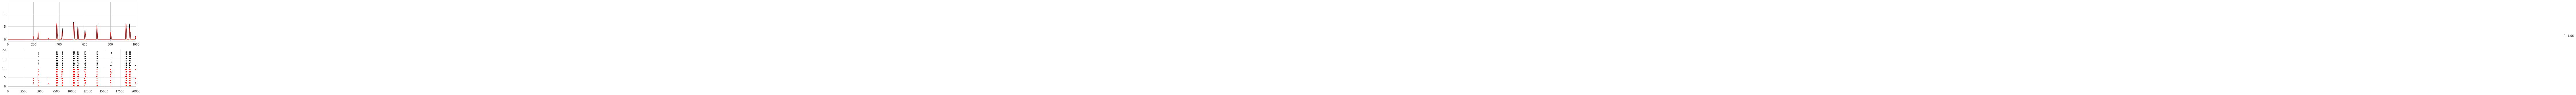

In [18]:
from dstrf import spikes, performance

duration = 20000
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
# posterior prediction
spike_v = np.stack([d["spike_v"] for d in test_data], axis=1)
spike_h = np.stack([d["H"] for d in test_data], axis=2)    
mltest = mle.mat(test_stim, kcosbas, spike_v, spike_h, stim_dt, model_dt, nlin="exp")

mparamp = matparams.copy()
samples = np.random.permutation(nwalkers)[:n_test]
pred_spikes = []
for i, idx in enumerate(samples):
    sample = pos[idx]
    V = mltest.V(sample)
    mparamp[matparams_i] = sample[:matparams_n]
    S = predict_spikes_voltage(V, mparamp, model_dt, upsample)
    spk_t = S.nonzero()[0]
    ax2.vlines(spk_t, i, i + 0.5, 'r')
    pred_spikes.append(S)

for j, d in enumerate(test_data):
    ax2.vlines(d["spike_t"], i + j + 1, i + j + 1.5)
    
test_psth = spikes.psth(spike_v, upsample, 1)    
pred_psth = spikes.psth(np.asarray(pred_spikes).T,upsample,1)

eo = performance.corrcoef(spike_v[::2], spike_v[1::2], upsample, 1)
cc = np.corrcoef(test_psth, pred_psth)[0, 1]
print("CC: {}/{} = {}".format(cc, eo, cc / eo))

ax1.plot(test_psth,linewidth=1,color='k',label="data")
ax1.plot(pred_psth,linewidth=1,color='r',label="estimate")    
t = ax1.text(duration,1.04,"$R$: {:.2f}".format(cc / eo),fontsize=10)
t.set_ha("right")

ax1.set_xlim(0, duration // upsample)
ax2.set_xlim(0, duration)

plt.savefig(outfile + "_predict.pdf")

In [19]:
a

NameError: name 'a' is not defined